8. In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

(a) Generate a Random Number for Predictor
𝑋
X and Noise Vector
𝑒
e:
We can use numpy to generate
𝑋
X and
𝑒
e, where both are normally distributed random numbers.

In [1]:
import numpy as np

# Parameters
n = 100  # Length of the data

# Create the random predictor X (normally distributed)
np.random.seed(42)  # For reproducibility
X = np.random.normal(0, 1, n)

# Create the noise vector e (normally distributed)
e = np.random.normal(0, 1, n)


(b) Generate a response vector Y of length n = 100 according to the model Y = β0 + β1X + β2X^2 + β3X^3 + e, where β0, β1, β2, and β3 are constants of your choice.


In [9]:
# Coefficients (chosen arbitrarily)
beta_0 = 2
beta_1 = 3
beta_2 = -1
beta_3 = 0.5

# Generate the response variable Y
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + e


Step (c): Forward Stepwise Selection
We can perform forward stepwise selection using the statsmodels library to calculate models and choose the best model using Cp. The Cp criterion can be used to choose a model that balances model complexity and fit.

We'll fit models for each subset of the predictors and calculate Cp for each model.

In [11]:
import statsmodels.api as sm
import pandas as pd

# Create the predictors X, X^2, ..., X^10
X_poly = np.column_stack([X**i for i in range(1, 11)])

# Add constant term (intercept)
X_poly = sm.add_constant(X_poly)

# Forward stepwise selection
def forward_stepwise(X, Y):
    n, p = X.shape
    selected_vars = []
    remaining_vars = list(range(p))  # Keep track of remaining variables
    best_model = None
    best_cp = np.inf

    while remaining_vars:
        cp_values = []
        for var in remaining_vars:
            # Try adding the next variable
            current_vars = selected_vars + [var]
            X_selected = X[:, current_vars]
            model = sm.OLS(Y, X_selected).fit()
            # Calculate Cp for this model
            residual_sum_of_squares = np.sum(model.resid**2)
            cp = (residual_sum_of_squares / n) + 2 * len(current_vars) - n
            cp_values.append((cp, current_vars, model.params))

        # Select the variable with the minimum Cp
        cp_values.sort(key=lambda x: x[0])
        best_cp, best_vars, best_coeffs = cp_values[0]

        selected_vars = best_vars
        remaining_vars = [var for var in remaining_vars if var not in best_vars]

    return best_vars, best_coeffs

# Run forward stepwise selection
best_vars, best_coeffs = forward_stepwise(X_poly, Y)
print(f"Best Variables (Forward Stepwise): {best_vars}")
print(f"Coefficients: {best_coeffs}")


Best Variables (Forward Stepwise): [1, 3, 0, 2, 10, 5, 9, 4, 8, 6, 7]
Coefficients: [ 2.447115    2.41520644  1.86944967 -1.85941674 -0.0763744  -2.09019344
 -0.11814616  3.01475617  0.73346599 -2.41302424  0.86391888]


Step (d): Backward Stepwise Selection
Backward stepwise selection starts with all variables and removes the least significant ones step by step. We can use similar logic to the forward stepwise approach.

In [12]:
# Backward stepwise selection
def backward_stepwise(X, Y):
    n, p = X.shape
    selected_vars = list(range(p))  # Start with all variables
    best_model = None
    best_cp = np.inf

    while len(selected_vars) > 1:
        cp_values = []
        for var in selected_vars:
            # Try removing the next variable
            current_vars = [v for v in selected_vars if v != var]
            X_selected = X[:, current_vars]
            model = sm.OLS(Y, X_selected).fit()
            # Calculate Cp for this model
            residual_sum_of_squares = np.sum(model.resid**2)
            cp = (residual_sum_of_squares / n) + 2 * len(current_vars) - n
            cp_values.append((cp, current_vars, model.params))

        # Select the model with the minimum Cp
        cp_values.sort(key=lambda x: x[0])
        best_cp, best_vars, best_coeffs = cp_values[0]

        selected_vars = best_vars

    return best_vars, best_coeffs

# Run backward stepwise selection
best_vars_b, best_coeffs_b = backward_stepwise(X_poly, Y)
print(f"Best Variables (Backward Stepwise): {best_vars_b}")
print(f"Coefficients: {best_coeffs_b}")


Best Variables (Backward Stepwise): [1]
Coefficients: [4.28057044]


We can use LassoCV from sklearn to fit a lasso model with cross-validation to select the optimal value of
𝜆
λ.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16768760646903047, tolerance: 0.15740739010205732
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20180048876977708, tolerance: 0.15740739010205732
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23039134889643265, tolerance: 0.15740739010205732
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: Co

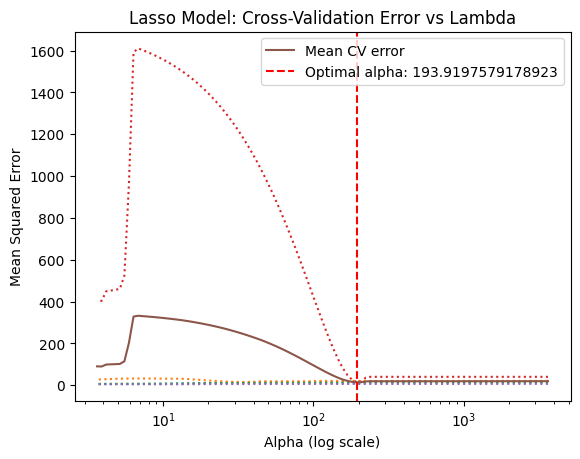

Lasso Coefficients: [ 0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.          0.         -0.00149194]


In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# Fit a Lasso model with cross-validation
lasso = LassoCV(cv=5)
lasso.fit(X_poly, Y)

# Plot cross-validation error as a function of lambda
plt.plot(lasso.alphas_, lasso.mse_path_, ':')
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=-1), label='Mean CV error')
plt.axvline(x=lasso.alpha_, linestyle='--', color='r', label=f'Optimal alpha: {lasso.alpha_}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Lasso Model: Cross-Validation Error vs Lambda')
plt.show()

# Report resulting coefficients
print(f"Lasso Coefficients: {lasso.coef_}")


Step (f): Generate New Response and Perform Forward Stepwise and Lasso Again
Here, we change the model to
𝑌
=
𝛽
0
+
𝛽
7
𝑋
7
+
𝑒
Y=β
0
​
 +β
7
​
 X
7
 +e.

Best Variables (Forward Stepwise - New Model): [7, 0, 2, 9, 5, 3, 4, 8, 6, 10, 1]
Coefficients: [ 2.36391888  1.86944967 -0.85941674 -0.11814616 -2.09019344  1.91520644
  3.01475617  0.73346599 -2.41302424 -0.0763744  -0.552885  ]


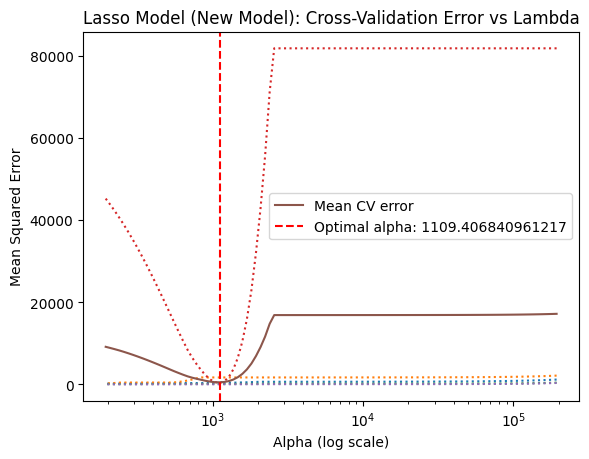

Lasso Coefficients (New Model): [ 0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.          0.19553794 -0.00885497]


In [14]:
# Generate new response vector Y based on a different model: Y = β0 + β7 * X^7 + e
beta_7 = 1.5
Y_new = beta_0 + beta_7 * X**7 + e

# Perform forward stepwise selection on the new model
best_vars_new, best_coeffs_new = forward_stepwise(X_poly, Y_new)
print(f"Best Variables (Forward Stepwise - New Model): {best_vars_new}")
print(f"Coefficients: {best_coeffs_new}")

# Fit a Lasso model to the new data
lasso_new = LassoCV(cv=5)
lasso_new.fit(X_poly, Y_new)

# Plot the cross-validation error for the new model
plt.plot(lasso_new.alphas_, lasso_new.mse_path_, ':')
plt.plot(lasso_new.alphas_, lasso_new.mse_path_.mean(axis=-1), label='Mean CV error')
plt.axvline(x=lasso_new.alpha_, linestyle='--', color='r', label=f'Optimal alpha: {lasso_new.alpha_}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Lasso Model (New Model): Cross-Validation Error vs Lambda')
plt.show()

# Report resulting coefficients for the new model
print(f"Lasso Coefficients (New Model): {lasso_new.coef_}")


Discussion
Forward vs. Backward Stepwise: The models obtained from forward and backward stepwise selections may differ depending on the initial set of variables considered and the inclusion/exclusion strategy. Forward stepwise starts with no predictors and adds one at a time, whereas backward stepwise starts with all predictors and removes one at a time.

Lasso Results: The Lasso method will shrink coefficients and set some of them to zero, especially when certain predictors are less important, which can be helpful for model interpretability and avoiding overfitting.